In [39]:
import pandas as pd
df = pd.read_csv(r"merged_raw_all.csv")
df.columns

Index(['valid_time', 'latitude', 'longitude', 'number', 'expver', 'csf', 'lsf',
       'bld', 'lgws', 'ewss', 'gwd', 'avg_esrwe', 'avg_tsrwe', 'd2m', 't2m',
       'msl', 'sp', 'u100', 'v100', 'u10n', 'v10n', 'hcc', 'lcc', 'mcc',
       'ptype', 'csfr', 'lssfr', 'tcsw', 'anor', 'isor', 'blh', 'zust', 'z',
       'tcslw', 'deg0l', 'fg10'],
      dtype='object')

## CODE CELL 1


In [63]:
import pandas as pd
import numpy as np

# Load the data
df = pd.read_csv(r"merged_raw_all.csv")
df1= df.drop(columns=['latitude', 'longitude', 'number'])


# Rename columns to more descriptive names
column_mapping = {
    # 'u100': '100m_u_component_of_wind', 
    # 'v100': '100m_v_component_of_wind',
    # 'u10n': '10m_u_component_of_wind',
    # 'v10n': '10m_v_component_of_wind',
    
    'fg10': '10m_wind_gust',
    'd2m': '2m_dewpoint_temperature',
    't2m': '2m_temperature',
    'anor': 'angle_of_sub_gridscale_orography',
    'isor': 'anisotropy_of_sub_gridscale_orography',
    'mser': 'mean_snow_evaporation_rate',
    'avg_tsrwe': 'mean_snowfall_rate',
    'cbh': 'cloud_base_height',
    'mcc': 'medium_cloud_cover',
    'ptype': 'precipitation_type',
    'sp': 'surface_pressure',
    'tcsw': 'total_column_snow_water',
    'tcslw': 'total_column_supercooled_liquid_water',
    'deg0l': 'zero_degree_level',
    'bld': 'boundary_layer_dissipation',
    'blh': 'boundary_layer_height',
    'cin': 'convective_inhibition',
    'csf': 'convective_snowfall',
    'csfr': 'convective_snowfall_rate_water_equivalent',
    'lgws': 'eastward_gravity_wave_surface_stress',
    'ewss': 'eastward_turbulent_surface_stress',
    'zust': 'friction_velocity',
    'z': 'geopotential',
    'gwd': 'gravity_wave_dissipation',
    'hcc': 'high_cloud_cover',
    'lssfr': 'large_scale_snowfall_rate_water_equivalent',
    'lsf': 'large_scale_snowfall',
    'lcc': 'low_cloud_cover',
    'msl': 'mean_sea_level_pressure'
}
df1.rename(columns=column_mapping, inplace=True)

# Convert valid_time to datetime with correct format
df1['valid_time'] = pd.to_datetime(df1['valid_time'], format='%Y-%m-%d %H:%M:%S')

# Add 6-hourly period identification
def assign_6hourly_period(timestamp):
    hour = timestamp.hour
    if 0 <= hour < 6:
        return timestamp.replace(hour=0, minute=0, second=0)
    elif 6 <= hour < 12:
        return timestamp.replace(hour=6, minute=0, second=0)
    elif 12 <= hour < 18:
        return timestamp.replace(hour=12, minute=0, second=0)
    else:
        return timestamp.replace(hour=18, minute=0, second=0)

df1['period'] = df1['valid_time'].apply(assign_6hourly_period)

def create_composite(group):
    """
    Create a composite row for each unique (period, lat, lon) combination
    with proper scientific aggregations.
    """
    # Initialize composite row
    composite_row = group.iloc[0].copy()
    
    # Define aggregation methods for different variable types
    mean_cols = [
        'wind_speed_10m', 'wind_speed_100m',
        'wind_dir_100m', 'wind_dir_10m',
        '2m_dewpoint_temperature', '2m_temperature',
        'mean_sea_level_pressure', 'surface_pressure',
        'boundary_layer_height', 'convective_inhibition',
        'friction_velocity', 'geopotential',
        'total_column_supercooled_liquid_water', 'zero_degree_level',
        'cloud_base_height'
    ]
    
    sum_cols = [
        'mean_snow_evaporation_rate', 'mean_snowfall_rate',
        'convective_snowfall_rate_water_equivalent',
        'large_scale_snowfall_rate_water_equivalent',
        'total_column_snow_water', 'convective_snowfall',
        'large_scale_snowfall',
        'boundary_layer_dissipation'  # Now correctly in sum_cols
    ]
    
    max_cols = [
        '10m_wind_gust',
        'high_cloud_cover', 'low_cloud_cover', 'medium_cloud_cover'
    ]
    
    # Apply aggregations
    for col in mean_cols:
        if col in group.columns:
            composite_row[col] = group[col].mean()
    
    for col in sum_cols:
        if col in group.columns:
            composite_row[col] = group[col].sum()
    
    for col in max_cols:
        if col in group.columns:
            composite_row[col] = group[col].max()
    
    # Handle categorical columns
    if 'precipitation_type' in group.columns:
        composite_row['precipitation_type'] = group['precipitation_type'].mode()[0] if not group['precipitation_type'].mode().empty else np.nan
    
    # Set the composite time
    composite_row['valid_time'] = group['period'].iloc[0]
    
    return composite_row

# Group by period, latitude, and longitude before applying composite
composite_df = df1.groupby(['period']).apply(create_composite).reset_index(drop=True)

# for col in mean_cols:
#         if col in group.columns:
#             composite_df[col] = composite_df[col].iloc[0]/6

# Convert back to original column names
reverse_mapping = {v: k for k, v in column_mapping.items()}
composite_df.rename(columns=reverse_mapping, inplace=True)

# # Save results
# output_path = r"C:\Users\pgd24-013121114\Downloads\findata\2024\6hourly_spatial_composite2.csv"
# composite_df.to_csv(output_path, index=False)

# print("\nProcessing complete. Results saved to:", output_path)
# print("Final composite data preview:")
# print(composite_df[['valid_time', 'latitude', 'longitude', 'bld', 't2m', 'msl']].head())

C:\Users\pgd24-013123975\AppData\Local\Temp\ipykernel_25248\911641990.py:122: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  composite_df = df1.groupby(['period']).apply(create_composite).reset_index(drop=True)


## CODE CELL 2


In [2]:
# df.head()
# df1=composite_df.drop(columns = ['cbh', 'cin'])
df1 = composite_df.copy()
df1.rename(columns={'avg_tsrwe': 'msr'}, inplace=True)
df1.head()
# df['msr']

,valid_time,expver,csf,lsf,bld,lgws,ewss,gwd,avg_esrwe,msr,...,tcsw,anor,isor,blh,zust,z,tcslw,deg0l,fg10,period
0,2020-01-01 00:00:00,1,0.000000,0.000165,1.785811e+07,0.074219,-3.089844,-2.352273,-3.910827e-10,0.000045,...,1.697320,0.069734,0.335117,87.414668,0.069211,21241.332633,0.000904,1241.604849,11.858847,2020-01-01 00:00:00
1,2020-01-01 06:00:00,1,0.000614,0.004572,1.745330e+07,-0.585938,-293.017820,6.275649,-7.639756e-10,0.001441,...,11.483272,0.069734,0.335117,711.861365,0.109736,21241.332633,0.008126,1211.113777,15.095576,2020-01-01 06:00:00
2,2020-01-01 12:00:00,1,0.000497,0.010306,9.342294e+06,0.830566,-12.405273,4.615299,-4.237108e-10,0.003000,...,22.653419,0.069734,0.335117,29.093068,0.038948,21241.332633,0.004730,1240.226128,10.453327,2020-01-01 12:00:00
3,2020-01-01 18:00:00,1,0.002537,0.025585,8.588660e+06,0.289551,-9.126709,0.881665,-1.491571e-10,0.007811,...,24.493385,0.069734,0.335117,27.974518,0.060874,21241.332633,0.006073,1223.402530,11.380462,2020-01-01 18:00:00
4,2020-01-02 00:00:00,1,0.000566,0.008721,5.583350e+06,-0.237549,-24.880127,-3.379859,-2.961542e-11,0.002579,...,21.179668,0.069734,0.335117,81.656634,0.079649,21241.332633,0.007711,1198.835317,10.871886,2020-01-02 00:00:00


In [45]:
df1.to_csv('Composite_data', index=False)

In [70]:
df1.columns

Index(['valid_time', 'expver', 'csf', 'lsf', 'bld', 'lgws', 'ewss', 'gwd',
       'avg_esrwe', 'msr', 'd2m', 't2m', 'msl', 'sp', 'u100', 'v100', 'u10n',
       'v10n', 'hcc', 'lcc', 'mcc', 'ptype', 'csfr', 'lssfr', 'tcsw', 'anor',
       'isor', 'blh', 'zust', 'z', 'tcslw', 'deg0l', 'fg10', 'period'],
      dtype='object')

In [3]:
from sklearn.preprocessing import StandardScaler

In [7]:
df1 = df1.sort_index()
y = df1['msr']
X = df1.drop(columns=['msr'])

scaler = StandardScaler()


In [18]:
df1.time = pd.to_datetime(df1.time)

In [19]:
df1.set_index('time', inplace=True)
df1.head()

,fg10,d2m,t2m,anor,isor,bld,blh,csf,csfr,lgws,...,ptype,sp,tcsw,tcslw,deg0l,month,wind_speed_100m,wind_speed_10m,wind_dir_100m,wind_dir_10m
time,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,9.254387,259.01220,270.72714,-0.843755,0.561664,26634.250,43.882690,0.0,0.0,-1205.896500,...,0.0,78958.914,0.000000,0.000626,1056.2698,1,3.276057,0.774719,202.799554,204.695790
2015-01-01 06:00:00,8.013790,261.87717,281.13336,-0.843755,0.561664,11570.281,402.298580,0.0,0.0,-597.325700,...,0.0,79215.484,0.000000,0.000144,1164.4120,1,2.017026,1.788267,197.953243,197.305075
2015-01-01 12:00:00,4.681635,262.47580,282.61460,-0.843755,0.561664,6521.625,68.859985,0.0,0.0,254.463870,...,0.0,78978.990,0.000150,0.000000,1165.0331,1,1.261297,0.163875,256.002796,249.766367
2015-01-01 18:00:00,4.830484,262.31497,275.22678,-0.843755,0.561664,8337.250,28.060547,0.0,0.0,-43.889404,...,0.0,79103.930,0.000299,0.000000,1340.7157,1,1.832312,0.428064,207.211239,208.309836
2015-01-02 00:00:00,5.102464,257.88873,273.75418,-0.843755,0.561664,4331.125,31.581787,0.0,0.0,-11.436768,...,0.0,78943.300,0.001199,0.021375,1295.4559,1,2.381101,0.522022,226.148281,210.370042


## CODE CELL 3


In [3]:
# If datetime is in a column (e.g., 'date')
df1['period'] = pd.to_datetime(df1['period'])
df1.set_index('period', inplace=True)  # Set as index
df1 = df1.sort_index()
print(df1.index.is_monotonic_increasing)  # Should return True


True


In [7]:
# len(df1)
df2 = df1.copy()
df2 = df2.resample('6h').mean()
df2.index.freq = '6h'
print(df2.index.freq)
# len(df2)

<6 * Hours>


In [8]:
# duplicates = df1[df1.index.duplicated(keep=False)]
# print(duplicates)
index_counts = df1.index.value_counts()
print(index_counts)

period
2024-12-31 18:00:00    1
2020-01-01 00:00:00    1
2020-01-01 06:00:00    1
2020-01-01 12:00:00    1
2020-01-01 18:00:00    1
                      ..
2020-01-06 18:00:00    1
2020-01-07 00:00:00    1
2020-01-07 06:00:00    1
2020-01-07 12:00:00    1
2020-01-07 18:00:00    1
Name: count, Length: 3028, dtype: int64


## CODE CELL 4


In [38]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Assume 'df1' is your original DataFrame
# Separate features and target variable
X = df1.drop('msr', axis=1)
y = df1['msr']

# Define the train and test years
train_years = range(2020, 2023)  # Training data from 2020-2022
test_years = [2023]  # Test data for 2023

# -----------------✅ Step 1: Extract Seasonal Data for Train & Test ✅ -----------------
def extract_seasonal_data(X, y, years):
    """Extract data from Oct to Feb for specified years with 6-hour frequency."""
    X_seasonal = []
    y_seasonal = []
    
    for year in years:
        # Define start and end for the season
        start_date = pd.Timestamp(f'{year}-10-01')
        
        # Handle Feb 29 for leap years
        try:
            end_date = pd.Timestamp(f'{year+1}-02-29')
        except ValueError:
            end_date = pd.Timestamp(f'{year+1}-02-28')
        
        # Create full 6-hour frequency for this period
        full_index = pd.date_range(start=start_date, end=end_date, freq='6H')
        
        # Reindex X and y to this seasonal period with 6-hour frequency
        X_period = X.loc[start_date:end_date].reindex(full_index)
        y_period = y.loc[start_date:end_date].reindex(full_index)
        
        # Handle missing values if necessary
        X_period = X_period.fillna(method='ffill')
        y_period = y_period.fillna(method='ffill')
        
        # Append to list
        X_seasonal.append(X_period)
        y_seasonal.append(y_period)
    
    # Concatenate all seasonal data
    X_seasonal = pd.concat(X_seasonal)
    y_seasonal = pd.concat(y_seasonal)
    
   # Explicitly set frequency after concat
    X_seasonal.index.freq = pd.infer_freq(X_seasonal.index)
    y_seasonal.index.freq = pd.infer_freq(y_seasonal.index)
    
    return X_seasonal, y_seasonal

# Extract seasonal data for training and testing
X_train, y_train = extract_seasonal_data(X, y, train_years)
X_test, y_test = extract_seasonal_data(X, y, test_years)

# X_train_2 = X_train.copy()
# y_train_2 = y_train.copy()

# X_train_2= X_train_2.resample('6h').mean()
# X_train_2.index.freq = '6h'
# y_train_2= y_train_2.resample('6h').mean()
# y_train_2.index.freq = '6h'

# X_train = X_train_2.dropna()
# y_train = y_train_2.dropna()
# print(X_train_2.index.freq)
# print(y_train_2.index.freq)
# print(len(X_train_2))
# print(len(X_train))
# print(len(y_train_2))
# print(len(y_train))

# -----------------✅ Step 2: Scaling Numeric Columns ✅ -----------------
# Identify numeric columns for scaling
numeric_columns = X_train.select_dtypes(include=['float64', 'int64']).columns

# Initialize the scaler
scaler = StandardScaler()

# Scale only numeric columns
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
X_test_scaled[numeric_columns] = scaler.transform(X_test[numeric_columns])

# y_train_scaled = scaler.transform(y_train.to_frame())
# y_test_scaled = scaler.transform(y_test.to_frame())

# -----------------✅ Step 3: Verify Results ✅ -----------------
print("Training data seasons:", X_train.index.year.unique())
print("Test data seasons:", X_test.index.year.unique())
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print(f"y_train frequency: {y_train.index.freq}")
print(f"y_test frequency: {y_test.index.freq}")



Training data seasons: Index([2020, 2021, 2022, 2023], dtype='int32')
Test data seasons: Index([2023, 2024], dtype='int32')
X_train shape: (1803, 32)
X_test shape: (605, 32)
y_train shape: (1803,)
y_test shape: (605,)
y_train frequency: None
y_test frequency: <6 * Hours>


C:\Users\pgd24-013123975\AppData\Local\Temp\ipykernel_25248\1387965952.py:31: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_index = pd.date_range(start=start_date, end=end_date, freq='6H')
C:\Users\pgd24-013123975\AppData\Local\Temp\ipykernel_25248\1387965952.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_period = X_period.fillna(method='ffill')
C:\Users\pgd24-013123975\AppData\Local\Temp\ipykernel_25248\1387965952.py:39: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y_period = y_period.fillna(method='ffill')


In [37]:
# print(y_train_2['2021-03-01 00:00:00'])
# y_train_2 = y_train_2.dropna()
print(len(y_train_2))
print(y_train_2.index.freq)

3521
<6 * Hours>


In [39]:
# print(f"X_train frequency: {X_train.index.freq}")
# print(f"y_train frequency: {y_train.index.freq}")
# print(f"X_test frequency: {X_test.index.freq}")
# print(f"y_test frequency: {y_test.index.freq}")
y_test.tail()

2024-02-28 00:00:00    0.000536
2024-02-28 06:00:00    0.000044
2024-02-28 12:00:00    0.000134
2024-02-28 18:00:00    0.000083
2024-02-29 00:00:00    0.000075
Freq: 6h, Name: msr, dtype: float64

In [40]:
# Check for non-numeric columns
# non_numeric_cols = df1.select_dtypes(exclude=['number']).columns
# print("Non-numeric columns:", non_numeric_cols)
# df1.info()
df1.isnull().sum()

valid_time    0
expver        0
csf           0
lsf           0
bld           0
lgws          0
ewss          0
gwd           0
avg_esrwe     0
msr           0
d2m           0
t2m           0
msl           0
sp            0
u100          0
v100          0
u10n          0
v10n          0
hcc           0
lcc           0
mcc           0
ptype         0
csfr          0
lssfr         0
tcsw          0
anor          0
isor          0
blh           0
zust          0
z             0
tcslw         0
deg0l         0
fg10          0
dtype: int64

In [17]:
# Training period: 2015 to 2019
train_data = df1['2015-01-01  00:00:00':'2019-12-31 18:00:00']
y_train = train_data['msr']
X_train = train_data.drop(columns=['msr'])

# Testing period: 2020
test_data = df1['2020-01-01 00:00:00':'2020-12-31 18:00:00']
y_test = test_data['msr']
X_test = test_data.drop(columns=['msr'])



In [19]:
train_data.head()
y_train


time
2015-01-01 00:00:00    0.000613
2015-01-01 06:00:00    0.000775
2015-01-01 12:00:00    0.000784
2015-01-01 18:00:00    0.001266
2015-01-02 00:00:00    0.005217
                         ...   
2019-12-30 18:00:00    0.000038
2019-12-31 00:00:00    0.000026
2019-12-31 06:00:00    0.000021
2019-12-31 12:00:00    0.000576
2019-12-31 18:00:00    0.000034
Name: msr, Length: 2404, dtype: float64

## CODE CELL 5


In [41]:
from statsmodels.tsa.stattools import adfuller

# ADF test for stationarity
result = adfuller(y_train)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# Apply differencing if necessary
if result[1] > 0.05:
    y_train_diff = y_train.diff().dropna()
else:
    y_train_diff = y_train


ADF Statistic: -14.033991493894412
p-value: 3.3950676833419333e-26


In [47]:
numeric_columns = X_train.select_dtypes(include=['float64', 'int64'])
numeric_columns.head()
X_train_data_index = X_train.index
X_train_data_index

DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 06:00:00',
               '2015-01-01 12:00:00', '2015-01-01 18:00:00',
               '2015-01-02 00:00:00', '2015-01-02 06:00:00',
               '2015-01-02 12:00:00', '2015-01-02 18:00:00',
               '2015-01-03 00:00:00', '2015-01-03 06:00:00',
               ...
               '2019-12-29 12:00:00', '2019-12-29 18:00:00',
               '2019-12-30 00:00:00', '2019-12-30 06:00:00',
               '2019-12-30 12:00:00', '2019-12-30 18:00:00',
               '2019-12-31 00:00:00', '2019-12-31 06:00:00',
               '2019-12-31 12:00:00', '2019-12-31 18:00:00'],
              dtype='datetime64[ns]', name='time', length=2404, freq=None)

In [ ]:
# X_train_data_index = X_train.index
# #X_train_data = X_train.columns
# X_train_data = X_train.select_dtypes(include=['float64', 'int64'])


# scaler = StandardScaler()

# X_test_data_index = X_test.index
# #X_test_data = X_test.columns
# X_test_data = X_test.select_dtypes(include=['float64', 'int64'])

# X_train_scaled_var = scaler.fit_transform(X_train_data)
# X_test_scaled_var = scaler.transform(X_test_data)

# X_train_scaled = pd.DataFrame(X_train_scaled_var, 
#                           index=X_train_data_index, 
#                           columns=X_train_data)

# X_test_scaled = pd.DataFrame(X_test_scaled_var, 
#                           index=X_test_data_index, 
#                           columns=X_test_data)




In [72]:
# X_train_numeric = X_train_numeric.diff().dropna().asfreq('6h')
# print(y_train_diff.index.freq) 
# print(y_train_diff.index.inferred_freq)
# y_train_diff = y_train_diff.sort_index()
# time_diffs = y_train.index[1:] - y_train.index[:-1]
# print(set(time_diffs)) 
# print(y_train.index[np.where(y_train.index.to_series().diff() > pd.Timedelta(days=213))[0]])

# # Check the full date range of your time series
# print("Start date:", y_train.index[0])
# print("End date:", y_train.index[-1])
# large_delta_indices = np.where(y_train.index.to_series().diff() > pd.Timedelta(days=244))[0]
# print("Indices with large time delta:", large_delta_indices)
# y_train
# len(y_train_diff)
df1.columns
df1=df1.drop('valid_time', axis=1)


## CODE CELL 6


In [42]:
X_train_numeric = X_train_scaled.select_dtypes(include=['float64', 'int64'])


# Convert to numpy array to ensure compatibility
X_train_numeric_array = np.asarray(X_train_numeric)

In [43]:
print(len(X_train_numeric_array))

1803


## CODE CELL 7


In [44]:
# X_test_scaled = X_test_scaled.select_dtypes(include=['float64', 'int64'])
# 
X_test_scaled.drop('valid_time', axis=1, inplace=True)

In [45]:
len(X_test_scaled.columns)

31

## CODE CELL 8


In [46]:
threshold = 1e-8 # adjust this based on your data characteristics

# Calculate the mean of non-near-zero values
non_zero_mean = y_train[abs(y_train) > threshold].mean()

# Create a copy of the original series
y_train_cleaned = y_train.copy()

# Replace near-zero values with the mean
y_train_cleaned.loc[abs(y_train_cleaned) <= threshold] = non_zero_mean
print(len(y_train_cleaned))

1803


In [21]:
# Ensure continuous time index within the Oct-Feb periods
def prepare_seasonal_series(y_train):
    # Group data by year to handle each Oct-Feb period separately
    years = y_train.index.year.unique()
    
    prepared_series_list = []
    
    for year in years:
        # Select data for each Oct-Feb period
        year_start = pd.Timestamp(f'{year}-10-01')
        
        # Dynamically determine the correct end date
        try:
            next_year_feb_end = pd.Timestamp(f'{year+1}-02-29')
        except ValueError:
            # If Feb 29 is invalid, use Feb 28
            next_year_feb_end = pd.Timestamp(f'{year+1}-02-28')
        
        # Extract data for this specific period
        year_data = y_train.loc[year_start:next_year_feb_end]
        
        # Create a full date range for this period with 6-hour frequency
        full_index = pd.date_range(
            start=year_start, 
            end=next_year_feb_end, 
            freq='6h'
        )
        
        # Reindex just this period's data
        year_data_reindexed = year_data.reindex(full_index)
        if len(year_data_reindexed) != len(full_index):
            print(f"Data mismatch in year {year}")

        
        prepared_series_list.append(year_data_reindexed)
    
    # Concatenate all prepared periods
    y_train_prepared = pd.concat(prepared_series_list)
    y_train_prepared = pd.concat(prepared_series_list)
    y_train_prepared = y_train_prepared[~y_train_prepared.index.duplicated(keep='last')]  # Or 'last'

    return y_train_prepared

# Prepare the time series
y_train_prepared = prepare_seasonal_series(y_train_diff)



In [ ]:
y_train_cleaned
# len(X_train_numeric_array)
# Convert to DataFrame to maintain index if necessary
# X_train_numeric_array = pd.DataFrame(X_train_numeric_array, index=y_train_diff.index)
# Assign 6-hour frequency to y_train_diff
y_train_diff.index.freq = '6H'

# Assign 6-hour frequency to X_train_numeric_array if it's a DataFrame
if isinstance(X_train_numeric_array, pd.DataFrame):
    X_train_numeric_array.index.freq = '6H'

## CODE CELL 9


In [56]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Check lengths
print(f"Length of y_train_diff: {len(y_train_cleaned)}")
print(f"Length of X_train_numeric_array: {len(X_train_numeric_array)}")

# Ensure lengths match
X_train_numeric_array = X_train_numeric_array[-len(y_train_cleaned):]

# Define and fit the SARIMAX model
model = SARIMAX(y_train_cleaned,
                exog=X_train_numeric_array,  # Include exogenous variables
                order=(2, 0, 2),  # ARIMA (p, d, q)
                seasonal_order=(2, 0, 2, 3),  # SARIMA (P, D, Q, S)
                # freq='6h',
                enforce_stationarity=False,
                enforce_invertibility=False)

# Fit the model
results = model.fit(disp=False)
print(results.summary())



Length of y_train_diff: 1803
Length of X_train_numeric_array: 1803


C:\Users\pgd24-013123975\AppData\Local\anaconda3\envs\proj_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\pgd24-013123975\AppData\Local\anaconda3\envs\proj_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                               msr   No. Observations:                 1803
Model:             SARIMAX(2, 0, 2)x(2, 0, 2, 3)   Log Likelihood                9924.508
Date:                           Sat, 29 Mar 2025   AIC                         -19769.016
Time:                                   15:29:43   BIC                         -19549.328
Sample:                                        0   HQIC                        -19687.907
                                          - 1803                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -7.6e-20         -0        inf      0.000    -7.6e-20    -7.6e-20
x1             0.0030      0.000      8.015

C:\Users\pgd24-013123975\AppData\Local\anaconda3\envs\proj_env\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3016: RuntimeWarning: divide by zero encountered in divide
  return self.params / self.bse


## CODE CELL 10


C:\Users\pgd24-013123975\AppData\Local\anaconda3\envs\proj_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\pgd24-013123975\AppData\Local\anaconda3\envs\proj_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


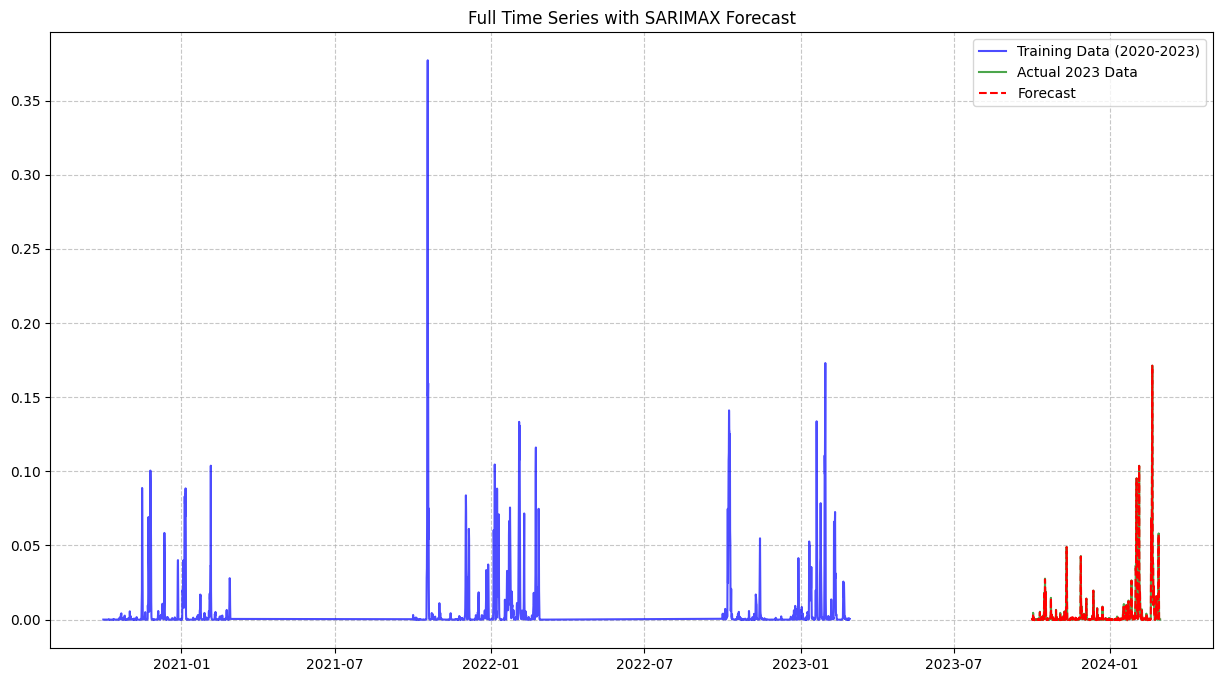

In [57]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


forecast_start = pd.Timestamp('2023-10-01')
forecast_end = pd.Timestamp('2024-02-29')
forecast_index = pd.date_range(start=forecast_start, end=forecast_end, freq='6h')

forecast = results.get_forecast(steps=len(forecast_index), exog=X_test_scaled)

# print(len(forecast_index))
# plt.plot(forecast_index, forecast.predicted_mean)
# plt.show()
# # Adjust forecast_mean and confidence intervals to match the new index
# # Create forecast mean with the new index
# forecast_mean = pd.Series(forecast.predicted_mean[:len(forecast_index)], 
#                           index=forecast_index)

# # Create confidence intervals with the new index
conf_int_values = forecast.conf_int(alpha=0.05)[:len(forecast_index)]
# conf_int = pd.DataFrame(conf_int_values, 
#                         index=forecast_index, 
#                         columns=['lower msr', 'upper msr'])
# forecast_mean.head()
# Create the plot with two subplots
plt.figure(figsize=(15, 8))

# # First subplot: Full time series with forecast
# plt.subplot(2, 1, 1)
plt.plot(y_train.index, y_train, label='Training Data (2020-2023)', color='blue', alpha=0.7)
plt.plot(y_test.index, y_test, label='Actual 2023 Data', color='green', alpha=0.7)
plt.plot(forecast_index, forecast.predicted_mean, label='Forecast', color='red', linestyle='--')
# plt.fill_between(conf_int.index, conf_int['lower msr'], conf_int['upper msr'], color='pink', alpha=0.3)

plt.title("Full Time Series with SARIMAX Forecast")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# # Second subplot: Zoomed in forecast with confidence interval
# plt.subplot(2, 1, 2)
# plt.plot(forecast_index, forecast.predicted_mean, label='Forecast Mean', color='red', linestyle='--')
# plt.fill_between(forecast_index, conf_int_values['lower msr'], conf_int_values['upper msr'], color='black', alpha=0.3, 
#                  label='95% Confidence Interval')
# plt.title("Detailed Forecast with Confidence Interval")
# plt.legend()
# plt.grid(True, linestyle='--', alpha=0.7)
# plt.tight_layout()
plt.show()
# # # Improve x-axis formatting for both subplots
# # for ax in plt.gcf().get_axes():
# #     ax.xaxis.set_major_locator(mdates.AutoDateLocator())
# #     ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# #     plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# plt.tight_layout()
# plt.show()

# # Additional visualization: Residual Analysis
# residuals = y_test - forecast_mean[:len(y_test)]
# print(residuals)

# plt.figure(figsize=(15, 6))
# plt.subplot(1, 2, 1)
# residuals.plot(kind='hist', bins=30, edgecolor='black')
# plt.title('Histogram of Residuals')
# plt.xlabel('Residual Value')
# plt.ylabel('Frequency')

# plt.subplot(1, 2, 2)
# plt.plot(residuals.index, residuals, marker='o')
# plt.title('Residuals Over Time')
# plt.xlabel('Date')
# plt.ylabel('Residual Value')
# plt.axhline(y=0, color='r', linestyle='--')
# plt.tight_layout()
# plt.show()

# # Print out some summary statistics
# print("Forecast Summary:")
# print("Forecast Mean:", forecast_mean.mean())
# print("Forecast Standard Deviation:", forecast_mean.std())
# print("\nResiduals Summary:")
# print("Mean Residual:", residuals.mean())
# print("Standard Deviation of Residuals:", residuals.std())
# print("Mean Absolute Error:", np.abs(residuals).mean())

## CODE CELL 11


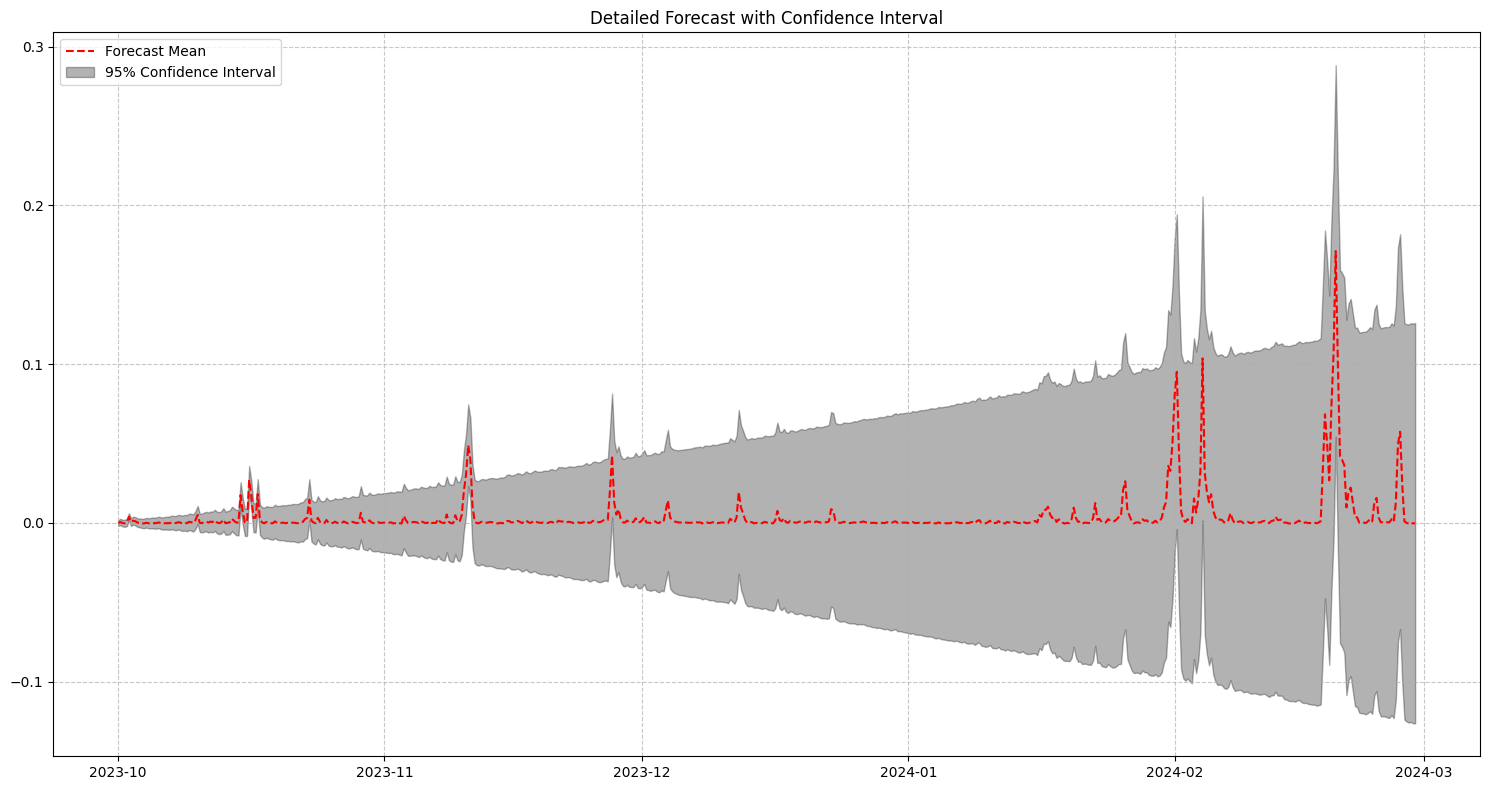

In [58]:
plt.figure(figsize=(15, 8))
plt.plot(forecast_index, forecast.predicted_mean, label='Forecast Mean', color='red', linestyle='--')
plt.fill_between(forecast_index, conf_int_values['lower msr'], conf_int_values['upper msr'], color='black', alpha=0.3, 
                 label='95% Confidence Interval')
plt.title("Detailed Forecast with Confidence Interval")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [59]:
conf_int_values = forecast.conf_int(alpha=0.05)[:len(forecast_index)]
print(conf_int_values)

      lower msr  upper msr
1803  -0.001952   0.001775
1804  -0.001477   0.002569
1805  -0.002177   0.001943
1806  -0.002479   0.001926
1807  -0.002072   0.002485
...         ...        ...
2403  -0.125097   0.125130
2404  -0.125721   0.124992
2405  -0.125409   0.125784
2406  -0.126192   0.125501
2407  -0.126269   0.125910

[605 rows x 2 columns]


In [60]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate error metrics
mse = mean_squared_error(y_test, forecast.predicted_mean)
mae = mean_absolute_error(y_test, forecast.predicted_mean)

print(f'Mean Squared Error (MSE): {mse:.16f}')
print(f'Mean Absolute Error (MAE): {mae:.16f}')


Mean Squared Error (MSE): 0.0000001725491634
Mean Absolute Error (MAE): 0.0003173958744370


## CODE CELL 12


Forecast Performance Metrics:
Mean Squared Error (MSE): 1.725491634373098e-07
Root Mean Squared Error (RMSE): 0.00041539037475284596
Mean Absolute Error (MAE): 0.000317395874436982
Mean Absolute Percentage Error (MAPE): 139816.89315544424
R-squared (R²): 0.9991261006602352
Mean of Residuals: 3.399452288744487e-05
Standard Deviation of Residuals: 0.00041399702396389856
Skewness of Residuals: -1.3475106440603508
Kurtosis of Residuals: 1.9924835687034603
Normalized Mean Absolute Error (NMAE): 0.0018533294757580691
Normalized Root Mean Squared Error (NRMSE): 0.0024255363332660214


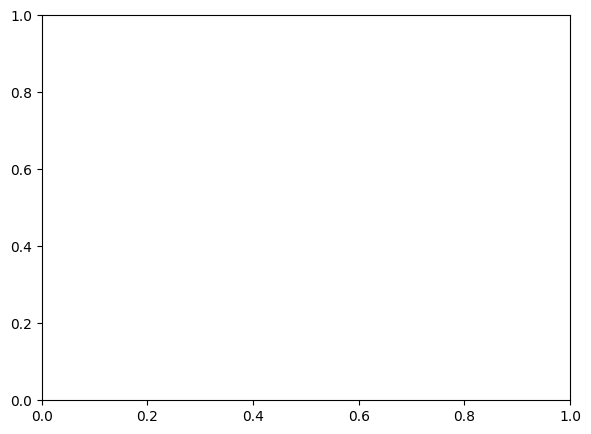

In [61]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
    mean_absolute_percentage_error,
    r2_score
)
from scipy import stats

def custom_mean_absolute_percentage_error(y_true, y_pred):
    """
    Custom MAPE calculation with handling for zero and near-zero values
    
    Parameters:
    y_true (array-like): True values
    y_pred (array-like): Predicted values
    
    Returns:
    float: Mean Absolute Percentage Error
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    
    # Mask for non-zero true values
    mask = y_true != 0
    
    # Calculate percentage errors only for non-zero true values
    percentage_errors = np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]) * 100
    
    # Return mean of percentage errors
    return np.mean(percentage_errors)

def comprehensive_forecast_evaluation(y_true, y_pred):
    """
    Comprehensive evaluation of forecast performance
    
    Parameters:
    y_true (array-like): Actual values
    y_pred (array-like): Predicted values
    
    Returns:
    Dictionary of various performance metrics
    """
    # Ensure numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Basic Error Metrics
    metrics = {}
    metrics['Mean Squared Error (MSE)'] = mean_squared_error(y_true, y_pred)
    metrics['Root Mean Squared Error (RMSE)'] = np.sqrt(mean_squared_error(y_true, y_pred))
    metrics['Mean Absolute Error (MAE)'] = mean_absolute_error(y_true, y_pred)
    
    # Handle MAPE carefully to avoid division by zero
    try:
        metrics['Mean Absolute Percentage Error (MAPE)'] = custom_mean_absolute_percentage_error(y_true, y_pred)
    except Exception as e:
        metrics['Mean Absolute Percentage Error (MAPE)'] = np.nan
    
    metrics['R-squared (R²)'] = r2_score(y_true, y_pred)
    
    # Additional Statistical Metrics
    residuals = y_true - y_pred
    
    metrics['Mean of Residuals'] = np.mean(residuals)
    metrics['Standard Deviation of Residuals'] = np.std(residuals)
    
    try:
        metrics['Skewness of Residuals'] = stats.skew(residuals)
        metrics['Kurtosis of Residuals'] = stats.kurtosis(residuals)
    except Exception as e:
        metrics['Skewness of Residuals'] = np.nan
        metrics['Kurtosis of Residuals'] = np.nan
    
    # Normalized Metrics
    metrics['Normalized Mean Absolute Error (NMAE)'] = metrics['Mean Absolute Error (MAE)'] / (np.max(y_true) - np.min(y_true))
    metrics['Normalized Root Mean Squared Error (NRMSE)'] = metrics['Root Mean Squared Error (RMSE)'] / (np.max(y_true) - np.min(y_true))
    
    return metrics

# Compute and print metrics
evaluation_results = comprehensive_forecast_evaluation(y_test, forecast.predicted_mean)

# Print metrics safely
print("Forecast Performance Metrics:")
for metric, value in evaluation_results.items():
    print(f"{metric}: {value}")

# Residual Analysis Visualization
# plt.figure(figsize=(15, 5))

# # Residuals Histogram
# plt.subplot(1, 2, 1)
# residuals = y_test - forecast.predicted_mean
# print(residuals)
# plt.hist(residuals, bins=30, edgecolor='black')
# plt.title('Histogram of Residuals')
# plt.xlabel('Residual Value')
# plt.ylabel('Frequency')

# # Q-Q Plot for Normality Check
# plt.subplot(1, 2, 2)
# stats.probplot(residuals, plot=plt)
# plt.title('Q-Q Plot of Residuals')

# plt.tight_layout()
# plt.show()

## CODE CELL 13


MAPE Diagnostic Information:
Total data points: 605
Points used in MAPE calculation: 579
Percentage of data points used: 95.70%
Min percentage error: 0.01931491927462809
Max percentage error: 4014986.003724677


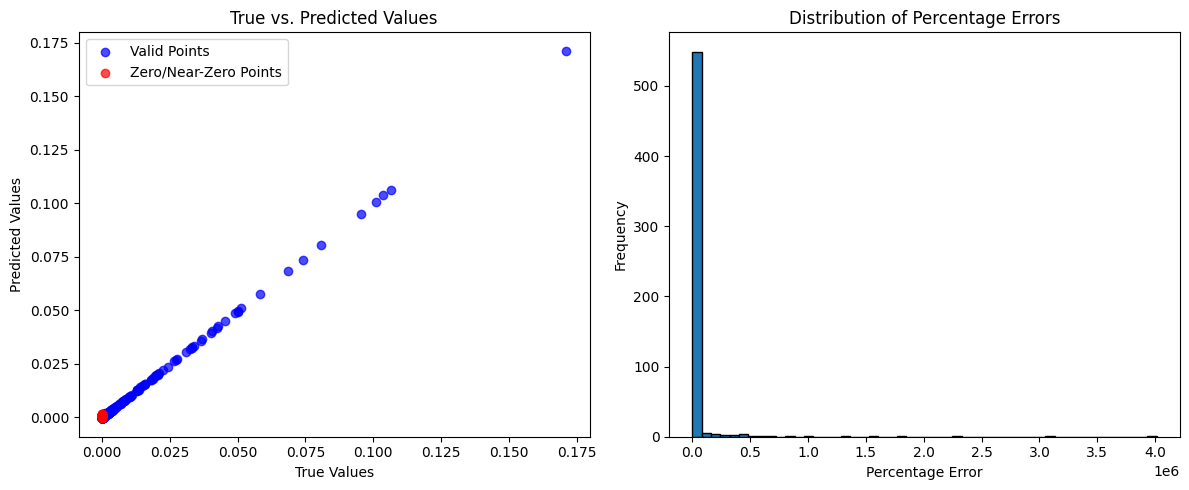


Calculated MAPE: 40528.15947345397

Data Characteristics:
y_test min: 0.0
y_test max: 0.171257123241488
y_test mean: 0.004151228293928623
y_test std: 0.01405159821933088

Forecast Characteristics:
Forecast min: -0.0004279685955269879
Forecast max: 0.17122404506638186
Forecast mean: 0.0041172337710411785
Forecast std: 0.013965138472216634


In [62]:
import numpy as np
import matplotlib.pyplot as plt

def safe_mape_calculation(y_true, y_pred, threshold=1e-8):
    """
    Calculate Mean Absolute Percentage Error with robust handling of zero and near-zero values
    
    Parameters:
    y_true (array-like): True values
    y_pred (array-like): Predicted values
    threshold (float): Minimum value to consider non-zero
    
    Returns:
    float: Mean Absolute Percentage Error
    """
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    
    # Mask for values that are significantly non-zero
    mask = np.abs(y_true) > threshold
    
    # If no valid values, return NaN
    if np.sum(mask) == 0:
        return np.nan
    
    # Calculate percentage errors for valid values
    percentage_errors = np.abs((y_true[mask] - y_pred[mask]) / np.maximum(np.abs(y_true[mask]), threshold)) * 100
    
    # Detailed diagnostic information
    print("MAPE Diagnostic Information:")
    print(f"Total data points: {len(y_true)}")
    print(f"Points used in MAPE calculation: {np.sum(mask)}")
    print(f"Percentage of data points used: {np.sum(mask) / len(y_true) * 100:.2f}%")
    print(f"Min percentage error: {np.min(percentage_errors)}")
    print(f"Max percentage error: {np.max(percentage_errors)}")
    
    # Visualization of valid vs. invalid points
    plt.figure(figsize=(12, 5))
    
    # Scatter plot of true vs. predicted values
    plt.subplot(1, 2, 1)
    plt.scatter(y_true[mask], y_pred[mask], label='Valid Points', color='blue', alpha=0.7)
    plt.scatter(y_true[~mask], y_pred[~mask], label='Zero/Near-Zero Points', color='red', alpha=0.7)
    plt.title('True vs. Predicted Values')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    
    # Histogram of percentage errors
    plt.subplot(1, 2, 2)
    plt.hist(percentage_errors, bins=50, edgecolor='black')
    plt.title('Distribution of Percentage Errors')
    plt.xlabel('Percentage Error')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    # Return mean of percentage errors
    return np.mean(percentage_errors)

# Calculate MAPE with detailed diagnostics
mape = safe_mape_calculation(y_test, forecast.predicted_mean)
print(f"\nCalculated MAPE: {mape}")

# Additional context about the data
print("\nData Characteristics:")
print(f"y_test min: {np.min(y_test)}")
print(f"y_test max: {np.max(y_test)}")
print(f"y_test mean: {np.mean(y_test)}")
print(f"y_test std: {np.std(y_test)}")
print("\nForecast Characteristics:")
print(f"Forecast min: {np.min(forecast.predicted_mean)}")
print(f"Forecast max: {np.max(forecast.predicted_mean)}")
print(f"Forecast mean: {np.mean(forecast.predicted_mean)}")
print(f"Forecast std: {np.std(forecast.predicted_mean)}")